### Idea

且哥之前在語法學的 term paper 使用 PTT 語料，分析了<strong>「V 看看」</strong> 和<strong>「VV 看」</strong>（e.g., 試看看 和 試試看）的動詞共現頻率和語境。
他發現

- <strong>「V 看看」</strong>出現的頻率更高、搭配的動詞種類也更多
- _試、問_ 等動詞明顯傾向與<strong>「V 看看」</strong>共現（2188 vs 5; 1539 vs 13）
- _瞧、攻_ 等動詞只有和<strong>「VV 看」</strong>共現的資料

不過且哥也想知道在 Dcard 論壇是不是也有相似的狀況，於是他想請你利用賦神爬取的 Dcard 貼文 raw data（197 個 folders，共 20069 個 json），找出

1. 在<strong>「V 看看」</strong>的 V-slot 最常出現的 10 個動詞和詞性（e.g., VC, VE, or VA)
2. 在<strong>「VV 看」</strong>的 V-slot 最常出現的 10 個動詞和詞性
3. 在兩個構式的 V-slot 出現次數總和最多的前 10 個動詞
4. 在兩個構式的 V-slot 出現次數差異最大的前 10 個動詞
5. 在兩個構式的 V-slot 都有出現的動詞



### Environment Setting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import re
import os
import json
from tqdm import tqdm 
import joblib
import pickle

### Preprocess posts

In [ ]:
forum_folders1 = os.listdir("./data/dcard_popular")
forum_folders2 = os.listdir("./data/dcard_latest")

len(forum_folders1), len(forum_folders2)

99

In [ ]:
# dcard_popular (forum_folders1)
posts = []
for forum in tqdm(forum_folders1):
    if forum != ".DS_Store":
        forum_path = f"./data/dcard_popular/{forum}"
        jsonfiles = os.listdir(forum_path)
        for jsonfile in jsonfiles:
            jsonpath = f"{forum_path}/{jsonfile}"
            with open(jsonpath, "r", encoding="utf-8") as f:
                post = json.load(f)
                posts.append(post)
len(posts)

100%|██████████| 99/99 [00:00<00:00, 674.17it/s]


1529

In [ ]:
# dcard_latest (forum_folders2)
latest = []
for forum in tqdm(forum_folders2)):
    if forum != ".DS_Store":
        forum_path = f"./data/dcard_latest/{forum}"
        jsonfiles = os.listdir(forum_path)
        for jsonfile in jsonfiles:
            jsonpath = f"{forum_path}/{jsonfile}"
            with open(jsonpath, "r", encoding="utf-8") as f:
                post = json.load(f)
                latest.append(post)
len(latest)

In [ ]:
posts_v2 = posts + latest
#with open("./data/posts_v2.json", "w", encoding="utf-8") as f:
 #   json.dump(posts_v2, f, ensure_ascii=False)

**Read posts_v2.json**

In [4]:
with open("./data/posts_v2.json", "r", encoding="utf-8") as f:
    posts_v2 = json.load(f)

In [5]:
len(posts_v2)

20069

In [6]:
# Post metadata
for post in posts_v2[:1]:
    print(post.keys())

dict_keys(['id', 'title', 'content', 'excerpt', 'anonymousSchool', 'anonymousDepartment', 'pinned', 'forumId', 'replyId', 'createdAt', 'updatedAt', 'commentCount', 'likeCount', 'tags', 'topics', 'supportedReactions', 'withNickname', 'reportReason', 'hiddenByAuthor', 'meta', 'forumName', 'forumAlias', 'school', 'replyTitle', 'gender', 'personaSubscriptable', 'reactions', 'hidden', 'customStyle', 'isSuspiciousAccount', 'layout', 'withImages', 'withVideos', 'media', 'reportReasonText', 'mediaMeta', 'postAvatar'])


In [7]:
# pick out the columns we want
results = []
for p in posts_v2:
    data = [p['id'],  p['createdAt'], p['forumName'], p['gender'], p['title'], p['content'], p['topics'], p['commentCount'], p['likeCount']]
    results.append(data)

len(results)

20069

In [8]:
# create a dataframe
df = pd.DataFrame(results, columns=['id', 'createdAt', 'forum', 'gender', 'title','content','topics','commentCount','likeCount'])
df.head()

,id,createdAt,forum,gender,title,content,topics,commentCount,likeCount
0,233006165,2020-02-03T04:47:26.058Z,Apple,M,#問題 關於Siri,https://megapx-assets.dcard.tw/images/45dbac63...,"[Apple, 問題, 求救文]",0,3
1,233012413,2020-02-04T02:11:08.007Z,Apple,F,iPhone 11 啊啊啊啊啊啊啊啊😭,#問題\n#求救\n#急在線等\n#HELP \n\n\n本人使用iphone11\n今天無...,"[手機, iPhone]",3,0
2,232795451,2019-12-31T03:40:36.331Z,Apple,M,Apple 板 Mac 教學文章,哈囉大家好\n我是 Apple 板板主 Macintosh \n\n有鑑於版友有問題需要協助...,"[教學, Apple, 問題, macOS]",9,13
3,233010090,2020-02-03T14:59:06.646Z,Apple,M,請問大家都哪裡買五星梅花起子呀？,今天去了光華某家電子材料行\n\n希望買到可以拆macbook pro 的背蓋的梅花起子\n...,"[diy, 起子, 梅花, macbook, 累]",7,0
4,233005085,2020-02-02T20:05:18.803Z,Apple,M,要換iphone11 還是等iphone12,小弟菜味濃，若有錯誤麻煩多多包含😅😅\n小弟目前用8 使用約兩年，操作上都還很順，沒什麼大問...,"[iPhone, 手機, 詢問, 問題, Apple]",33,8


**Cleaning**

In [10]:
trash_re = "@\S+|https?:\S+|http?:\S|[^\u4E00-\u9FD5]"

def clean(texts, trash_re):
    output = []
    for text in texts:
        text = re.sub(trash_re, '', str(text))
        output.append(text)
    return output

def clean_title(texts):
    title_re = "@\S+|https?:\S+|http?:\S|\W"
    output = []
    for text in texts:
        text = re.sub(title_re, '', str(text))
        output.append(text)
    return output

In [11]:
df['content_clean'] = clean(df['content'], trash_re)
df.head()

,id,createdAt,forum,gender,title,content,topics,commentCount,likeCount,content_clean
0,233006165,2020-02-03T04:47:26.058Z,Apple,M,#問題 關於Siri,https://megapx-assets.dcard.tw/images/45dbac63...,"[Apple, 問題, 求救文]",0,3,請問一下如何刪除這個建議這隻手機是家人不要用給我用的爬了很多文章也不知道怎麼刪又或者是我搜尋...
1,233012413,2020-02-04T02:11:08.007Z,Apple,F,iPhone 11 啊啊啊啊啊啊啊啊😭,#問題\n#求救\n#急在線等\n#HELP \n\n\n本人使用iphone11\n今天無...,"[手機, iPhone]",3,0,問題求救急在線等本人使用今天無論如何都叫不出也看了設定都有開啟的服務不知道為什麼就是叫不出來...
2,232795451,2019-12-31T03:40:36.331Z,Apple,M,Apple 板 Mac 教學文章,哈囉大家好\n我是 Apple 板板主 Macintosh \n\n有鑑於版友有問題需要協助...,"[教學, Apple, 問題, macOS]",9,13,哈囉大家好我是板板主有鑑於版友有問題需要協助時無法在版找到答案想請各位板友提供問題或是想要了...
3,233010090,2020-02-03T14:59:06.646Z,Apple,M,請問大家都哪裡買五星梅花起子呀？,今天去了光華某家電子材料行\n\n希望買到可以拆macbook pro 的背蓋的梅花起子\n...,"[diy, 起子, 梅花, macbook, 累]",7,0,今天去了光華某家電子材料行希望買到可以拆的背蓋的梅花起子但結果他明明就是畫的一顆五角星星回家...
4,233005085,2020-02-02T20:05:18.803Z,Apple,M,要換iphone11 還是等iphone12,小弟菜味濃，若有錯誤麻煩多多包含😅😅\n小弟目前用8 使用約兩年，操作上都還很順，沒什麼大問...,"[iPhone, 手機, 詢問, 問題, Apple]",33,8,小弟菜味濃若有錯誤麻煩多多包含小弟目前用使用約兩年操作上都還很順沒什麼大問題只有電池續航力有...


In [14]:
# filter out rows that only has numbers in content_clean / len==1
str_rowids = []
for i,r in df.iterrows():
    if type(r['content_clean']) != float:
        if len(r['content_clean']) >1:
            str_rowids.append(i)

len(str_rowids)

20025

In [ ]:
df = df.iloc[str_rowids]

In [20]:
# remove duplicates
df.drop_duplicates("content_clean", inplace=True)
df.shape

(19898, 10)

In [21]:
#df.to_csv('./data/dcard_df_cleaned.csv',encoding='utf-8',index=False)

### Tokenization & POS tagging

In [21]:
df = pd.read_csv('./data/dcard_df_cleaned.csv',encoding='utf-8')

In [ ]:
!pip install ckip-transformers
from ckip_transformers.nlp import CkipWordSegmenter
from ckip_transformers.nlp import CkipPosTagger

In [22]:
# WS
ws_driver = CkipWordSegmenter(device=0)

In [23]:
dcard_ws = ws_driver(df['content_clean'], use_delim = False)
dcard_segmented = [" ".join(ls) for ls in dcard_ws]

Inference: 100%|██████████| 101/101 [13:13<00:00,  7.86s/it]


In [24]:
#joblib.dump(dcard_ws, "./data/dcard_ws.pkl")
#joblib.dump(dcard_segmented, "./data/dcard_segmented.pkl")

['./data/dcard_segmented.pkl']

In [25]:
# POS
pos_driver = CkipPosTagger(device=0)
dcard_pos = pos_driver(dcard_ws, use_delim = False)

Inference: 100%|██████████| 101/101 [13:23<00:00,  7.96s/it]


In [26]:
#joblib.dump(dcard_pos, "./data/dcard_pos.pkl")

['./data/dcard_pos.pkl']

**Make text only df**

In [27]:
text_df = pd.DataFrame({
    'PostId':df['id'].to_list(),
    'Content_ws':dcard_ws,
    'Content_pos':dcard_pos,
    'Content_segmented':dcard_segmented,
})

In [28]:
text_df.head()

,PostId,Content_ws,Content_pos,Content_segmented
0,233006165,"[請問, 一下, 如何, 刪除, 這, 個, 建議, 這, 隻, 手機, 是, 家人, 不要...","[VE, Nd, D, VC, Nep, Nf, Na, Nep, Nf, Na, SHI,...",請問 一下 如何 刪除 這 個 建議 這 隻 手機 是 家人 不要 用 給 我 用 的 爬 ...
1,233012413,"[問題, 求救, 急, 在, 線, 等, 本人, 使用, 今天, 無論如何, 都, 叫, 不...","[Na, VF, Na, P, Nc, Cab, Nh, VC, Nd, Dk, D, VC...",問題 求救 急 在 線 等 本人 使用 今天 無論如何 都 叫 不 出 也 看 了 設定 都...
2,232795451,"[哈囉, 大家, 好, 我, 是, 板板主, 有鑑於, 版友, 有, 問題, 需要, 協助,...","[I, Nh, VH, Nh, SHI, Na, Cbb, Na, V_2, Na, VK,...",哈囉 大家 好 我 是 板板主 有鑑於 版友 有 問題 需要 協助 時 無法 在 版 找到 ...
3,233010090,"[今天, 去, 了, 光華, 某, 家, 電子, 材料行, 希望, 買到, 可以, 拆, 的...","[Nd, VCL, Di, Na, Nes, Nf, Na, Nc, VK, VC, D, ...",今天 去 了 光華 某 家 電子 材料行 希望 買到 可以 拆 的 背蓋 的 梅花 起子 但...
4,233005085,"[小弟菜, 味, 濃, 若, 有, 錯誤, 麻煩, 多多, 包含, 小弟, 目前, 用, 使...","[Na, Na, VH, Cbb, V_2, Na, Na, D, VJ, Na, Nd, ...",小弟菜 味 濃 若 有 錯誤 麻煩 多多 包含 小弟 目前 用 使用 約 兩 年 操作 上 ...


## Find posts with V 看看

In [65]:
text_df = pd.read_pickle('./data/dcard_text_df.pkl')

In [66]:
v_list = []
v_poslist = []
kankan_texts= []
kankan_ids = []
for i, r in text_df.iterrows():
    if '看看' in r['Content_ws']:
        kk= r['Content_ws'].index('看看')
        if 'V' in r['Content_pos'][kk-1]:
            kankan_ids.append(i)
            if len(r['Content_pos'])>=8:
                kankan_texts.append(r['Content_ws'][kk-4:kk+4])
                v_list.append(r['Content_ws'][kk-1])
                v_poslist.append(r['Content_pos'][kk-1])
            else:
                kankan_texts.append(r['Content_ws'])
                v_list.append(r['Content_ws'][kk-1])
                v_poslist.append(r['Content_pos'][kk-1])
len(kankan_ids)

763

In [ ]:
pd.set_option('display.max_rows',1000)
kankan_df = text_df.iloc[kankan_ids]
kankan_df['Kankan_text'] = kankan_texts
kankan_df['FrontVerb'] = v_list
kankan_df['FrontVerb_pos'] = v_poslist
kankan_df['Type'] = '看看'
kankan_df = kankan_df[['PostId','FrontVerb','Type','Kankan_text','FrontVerb_pos','Content_ws','Content_pos']]

In [68]:
kankan_df.shape

(763, 7)

In [69]:
kankan_df = kankan_df.sort_values(by=['FrontVerb','PostId']).reset_index(drop=True)

In [75]:
kankan_df.head()

,PostId,FrontVerb,Type,Kankan_text,FrontVerb_pos,Content_ws,Content_pos
0,232873689,上上網,看看,"[平時, 一樣, 可以, 上上網, 看看, 影片, 還, 有]",VC,"[先, 說, 我, 目前, 的, 筆電, 是, 服役, 了, 年, 的, 就是, 之前, 能...","[D, VE, Nh, Nd, DE, Na, SHI, VA, Di, Nf, DE, C..."
1,232699296,上來,看看,"[交流, 於是, 分享, 上來, 看看, 大家, 有, 沒]",VA,"[和, 朋友, 一時, 興起, 定, 了, 一, 個, 題目, 做, 一, 個, 文字, 交...","[P, Na, Nd, VC, VC, Di, Neu, Nf, Na, VC, Neu, ..."
2,232799658,上來,看看,"[必須, 每, 天, 上來, 看看, 但, 只要, 看到]",VA,"[大家, 好, 我, 是, 米糕, 麻麻, 各位, 先, 不要, 檢舉, 我, 發, 錯, ...","[Nh, VH, Nh, SHI, Na, VH, Nes, D, D, VC, Nh, V..."
3,232972577,上來,看看,"[集, 了, 想, 上來, 看看, 大家, 有, 沒]",VA,"[哈嘍, 大家, 看到, 現在, 剩下, 集, 了, 想, 上來, 看看, 大家, 有, 沒...","[I, Nh, VE, Nd, VJ, Na, Di, VE, VA, VE, Nh, V_..."
4,232939403,上去,看看,"[女孩, 們, 可以, 上去, 看看, 喔猴猴, 賺, 這]",VA,"[對於, 一, 個, 打工, 收入, 微薄, 的, 窮, 大學生, 而言, 我, 自己, 覺...","[P, Neu, Nf, VA, Na, VH, DE, VH, Na, Ng, Nh, N..."


In [72]:
#kankan_df.to_pickle('./data/kankan_df.pkl')

### Top 10 Verb in V看看

In [9]:
def change_listofstring_tolist(texts):
    new_texts = []
    for text in texts:
        if type(text) == str:
            text = re.sub("\[|\]|\'",'',text)
            text = text.split(', ')
            new_texts.append(text)
        else:
            print(text)
            new_texts.append([])
    return new_texts

In [74]:
kankan_df = pd.read_pickle('./data/kankan_df.pkl')

In [76]:
kankan_result = kankan_df.groupby(["FrontVerb",'FrontVerb_pos'])['FrontVerb'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

In [77]:
#kankan_result.to_pickle('./data/kankan_result.pkl')

In [78]:
# 共現的動詞pos type數量
from collections import Counter 
Counter(kankan_result['FrontVerb_pos'])

Counter({'VE': 30,
         'VF': 5,
         'VC': 116,
         'VJ': 4,
         'VA': 53,
         'VH': 26,
         'VCL': 5,
         'VB': 10,
         'VK': 8,
         'VD': 4,
         'VL': 2,
         'VHC': 1,
         'VG': 1,
         'V_2': 1})

In [79]:
# 共現的動詞type數量
len(set(kankan_result['FrontVerb']))

258

In [80]:
# 共現次數summary
kankan_result['count'].describe()

count    266.000000
mean       2.868421
std        7.442457
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       76.000000
Name: count, dtype: float64

In [81]:
# 共現次數最多的前十個動詞
kankan_result.head(10)

,FrontVerb,FrontVerb_pos,count
38,問,VE,76
65,想,VE,66
42,嘗試,VF,44
28,參考,VC,43
256,體驗,VC,18
18,分享,VJ,18
184,詢問,VE,18
198,說,VE,13
78,找,VC,13
14,做,VC,13


**Plot 前10共現的V**

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

fm.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

In [4]:
kankan_result = pd.read_pickle('./data/kankan_result.pkl')

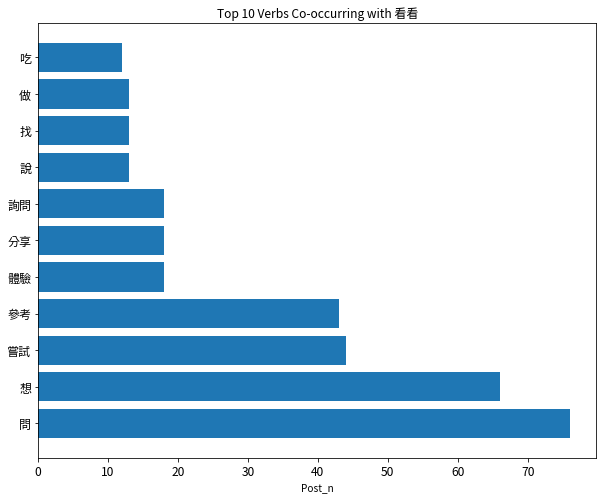

In [21]:
# plot

fig, ax = plt.subplots(figsize=(10,8))


df = kankan_result[:11]

#assigning variables
x = df['FrontVerb']
y = df['count']

#Graphing
plt.barh(x,y)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Top 10 Verbs Co-occurring with 看看")
plt.xlabel("Post_n")
plt.show()

### 想看看 vs 想看看

In [27]:
kankan_df = pd.read_pickle('./data/kankan_df.pkl')

In [28]:
pd.set_option('display.max_rows',1000)
kankan_df.loc[kankan_df['FrontVerb']=='想']['Kankan_text']

293      [看, 狄卡, 是, 想, 看看, 不同, 地方, 討論區]
294      [的, 文章, 無聊, 想, 看看, 能不能, 開版, 更]
295      [可以, 接受, 的, 想, 看看, 世界, 冠軍, 店家]
296       [膠囊, 的, 價錢, 想, 看看, 蝦皮, 或, 拍賣]
297      [便宜, 的, 所以, 想, 看看, 大家, 的, 環保袋]
298          [太, 到, 了, 想, 看看, 大家, 的, 殼]
299       [許多, 本來, 上, 想, 看看, 的, 超猛, 滑球]
300          [那, 我, 就, 想, 看看, 他, 的, 照片]
301        [我, 真的, 很, 想, 看看, 各位, 卡友, 都]
302          [連結, 我, 也, 想, 看看, 你, 是, 不]
303         [個, 是, 版, 想, 看看, 大家, 手帳, 都]
304        [搖頭, 但, 又, 想, 看看, 室友男, 是, 不]
305        [他, 現在, 只, 想, 看看, 眼前, 這, 冷清]
306         [有, 機會, 也, 想, 看看, 有, 沒有, 租]
307         [久, 了, 也, 想, 看看, 不同, 腔調, 的]
308    [喜歡, 推理片, 或是, 想, 看看, 美國, 隊長, 怎麼]
309       [右下方, 有, 下載鍵, 想, 看看, 上, 次, 的]
310         [上, 看到, 的, 想, 看看, 還, 有, 其他]
311        [大家, 想, 不, 想, 看看, 自己, 運氣, 好]
312       [所以, 愛上, 也, 想, 看看, 之後, 的, 發展]
313        [台灣, 買, 的, 想, 看看, 跟, 海外版, 有]
314           [一, 波, 也, 想, 看看, 還, 有, 沒]
315       [種, 款式, 太少, 想, 看看, 有, 沒有, 其他]
316          [嘛, 我, 好, 想, 看看, 的, 膠片, 呀]
317        [猶豫, 但, 還是, 想, 看看, 台灣, 有, 沒]


## Find posts with VV看

In [15]:
text_df = pd.read_pickle('./data/dcard_text_df.pkl')

In [49]:
# find regex of VV看
v_list = []
v_pos_list = []
k_texts= []
k_ids = []
for i, r in text_df.iterrows():
    if '看' in r['Content_ws']:
        kk= r['Content_ws'].index('看')
        if 'V' in r['Content_pos'][kk-1] and r['Content_pos'][kk-1]!='VH':
            if len(r['Content_ws'][kk-1])==2 or len(r['Content_ws'][kk-1])==4:
                front_verb = r['Content_ws'][kk-1]
                chars = list(front_verb)
                if len(chars)==2 and chars[0]==chars[1]:
                    front_verb = "".join(chars)
                    k_ids.append(kk)
                    v_list.append(front_verb)
                    v_pos_list.append(r['Content_pos'][kk-1])  
                    if kk <= (len(r['Content_ws'])-4) and kk >=4:
                        k_texts.append(r['Content_ws'][kk-4:kk+4])
                    else:
                        k_texts.append(r['Content_ws'])

                elif len(chars)==4:
                    dup = [x for x in chars if chars.count(x) > 1]
                    front_verb = "".join(dup)
                    k_ids.append(kk)
                    v_list.append(front_verb)
                    v_pos_list.append(r['Content_pos'][kk-1]) 
                    if kk <= (len(r['Content_ws'])-4) and kk >=4:
                        k_texts.append(r['Content_ws'][kk-4:kk+4])
                    else:
                        k_texts.append(r['Content_ws'])               
                    

In [ ]:
vvk_df = text_df.iloc[k_ids]
vvk_df['VVK_text'] = k_texts
vvk_df['FrontVerb'] = v_list
vvk_df['FrontVerb_pos'] = v_pos_list
vvk_df['Type'] = '看'
vvk_df = vvk_df[['PostId','FrontVerb','Type','VVK_text','Content_ws','Content_pos','FrontVerb_pos']]

In [51]:
vvk_df.shape

(441, 7)

In [52]:
vvk_df = vvk_df.sort_values(by=['FrontVerb','PostId']).reset_index(drop=True)
vvk_result = vvk_df.groupby(["FrontVerb",'FrontVerb_pos'])['FrontVerb'].count().reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

In [64]:
#vvk_df.to_pickle('./data/vvk_df.pkl')

In [62]:
#vvk_result.to_pickle('./data/vvk_result.pkl')

### Top 10 Verb in VV看

In [61]:
# 共現的動詞pos type數量
from collections import Counter 
Counter(vvk_result['FrontVerb_pos'])

Counter({'VE': 11, 'VF': 3, 'VC': 38, 'VA': 6, 'VJ': 1, 'VCL': 2, 'VD': 1})

In [58]:
# 共現的動詞type數量
len(set(vvk_result['FrontVerb']))

56

In [59]:
# 共現次數summary
vvk_result['count'].describe()

count    62.000000
mean      7.112903
std      16.298552
min       1.000000
25%       1.000000
50%       1.000000
75%       4.000000
max      81.000000
Name: count, dtype: float64

In [60]:
# 共現次數最多的前十個動詞
vvk_result.head(10)

,FrontVerb,FrontVerb_pos,count
47,試試,VE,81
7,問問,VE,81
48,試試,VF,59
43,聽聽,VE,28
46,試試,VC,26
6,吃吃,VC,17
3,做做,VC,15
15,找找,VC,12
8,喝喝,VC,12
30,玩玩,VC,10


**Plot 前10 共現的verb**

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

fm.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

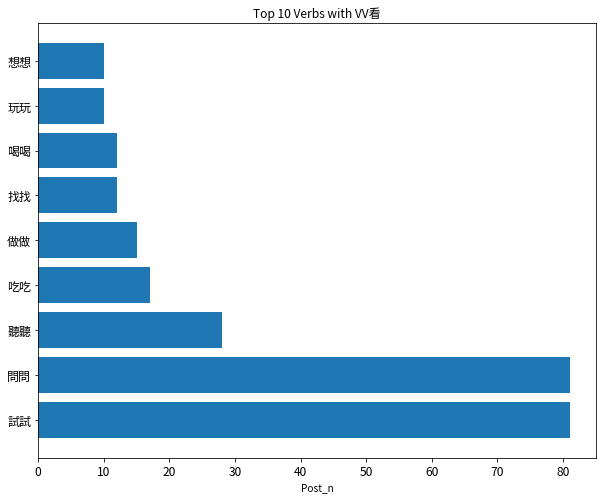

In [83]:
# plot

fig, ax = plt.subplots(figsize=(10,8))


df = vvk_result[:11]

#assigning variables
x = df['FrontVerb']
y = df['count']

#Graphing
plt.barh(x,y)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Top 10 Verbs with VV看")
plt.xlabel("Post_n")
plt.show()

## 總次數最多、相差次數最多、兩構式皆有

In [57]:
def plot_barh(data_df, x_col, y_col,titletext):
    fig, ax = plt.subplots(figsize=(10,8))
    df = data_df[:11]

    #assigning variables
    x = df[x_col]
    y = df[y_col]

    #Graphing
    plt.barh(x,y)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(titletext)
    plt.xlabel("Post_n")
    plt.show()

In [29]:
vvk_result = pd.read_pickle('./data/vvk_result.pkl')
kankan_result = pd.read_pickle('./data/kankan_result.pkl')

In [35]:
# 兩個各自的動詞dict
vvk_dict =dict(zip(vvk_result['FrontVerb'], vvk_result['count']))
kankan_dict = dict(zip(kankan_result['FrontVerb'], kankan_result['count']))

In [37]:
# 聯集動詞
union_verbs = []
for v in vvk_dict.keys():   # 這裡面的key是疊字
    union_verbs.append(v[0])

for v in kankan_dict.keys():   # 這裡面的key只有一個字
    union_verbs.append(v)

union_verbs = list(set(union_verbs))
len(union_verbs)

284

In [46]:
datalist = []
# 做成大表
for v in union_verbs:
    data = [v]
    if v in kankan_dict.keys():     # 有V看看
        data.append(kankan_dict[v])
    else:
        data.append(0)
    if (v*2) in vvk_dict.keys():    # 有vv看
        data.append(vvk_dict[(v*2)])
    else:
        data.append(0)
    
    sum = data[1]+data[2]
    gap = max(data[1], data[2]) - min(data[1], data[2])
    data.append(sum)
    data.append(gap)
    
    datalist.append(data)

len(datalist)

284

In [54]:
union_df = pd.DataFrame(datalist, columns=['FrontVerb', 'V看看_n', 'vv看_n', '出現總次數', '相差次數'])

In [56]:
union_df.to_pickle('./data/union_df.pkl')

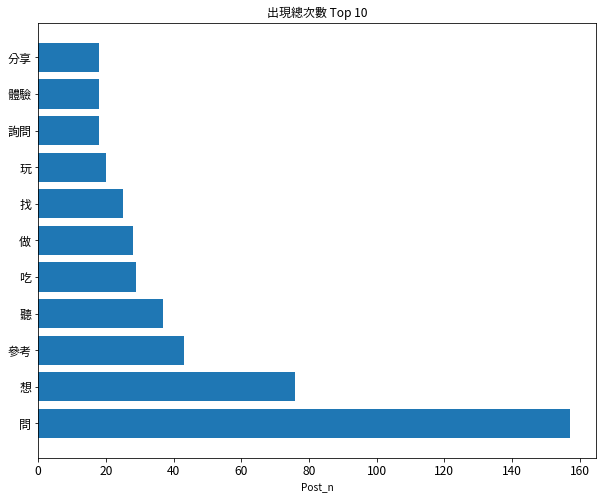

In [58]:
df = union_df.sort_values(['出現總次數'], ascending=False).reset_index(drop=True)
plot_barh(df, 'FrontVerb', '出現總次數', '出現總次數 Top 10')

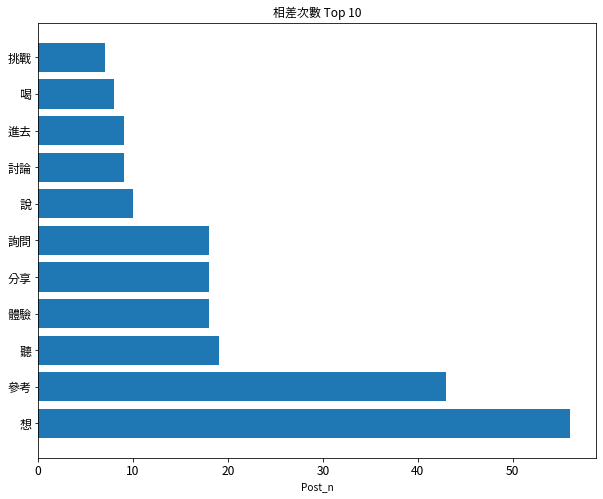

In [59]:
df = union_df.sort_values(['相差次數'], ascending=False).reset_index(drop=True)
plot_barh(df, 'FrontVerb', '相差次數', '相差次數 Top 10')

**兩構式皆有出現**

In [62]:
output = []
df = union_df.loc[(union_df['V看看_n']!=0) & (union_df['vv看_n']!=0)]
df.sort_values(['出現總次數'], ascending=False).reset_index(drop=True)

,FrontVerb,V看看_n,vv看_n,出現總次數,相差次數
0,問,76,81,157,5
1,想,66,10,76,56
2,聽,9,28,37,19
3,吃,12,17,29,5
4,做,13,15,28,2
5,找,13,12,25,1
6,玩,10,10,20,0
7,說,13,3,16,10
8,喝,4,12,16,8
9,用,3,9,12,6
